<a href="https://colab.research.google.com/github/pidipidi/cs577_RLI/blob/master/assignment_1/problem_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 3 - Real-world robot demonstrations using a Baxter robot

## Environment Setup

In [ ]:
import numpy as np
import sys, copy
import matplotlib.pyplot as plt

## A. Implement the improved DMP and train it with a 2-dimensional circular trajectory.

In this problem, you will implement the improved Dynamic Movement Primitives (DMPs) to learn and reproduce a 2-dimensional circular trajectory.

### Circular *Trajectory*
We first generate a circular trajectory. This trajectory will serve as the demonstration data for imitation. Using this demonstration, you will then implement the improved DMP formulation to reproduce the trajectory.

In [ ]:
def min_jerk(start, goal, dur, freq=100):
    """
    A function to generate a minimum-jerk trajectory.

    Parameters
    ----------
    start : array
        a vector of start position (e.g., np.array([0,0,0]))
    goal  : array
        a vector of goal position (e.g., np.array([1,2,1]))
    dur   : float
        time duration of the resulted trajectory
    freq  : float
        time frequency (Hz)

    Returns
    -------
    time : array
           a list of progress from 0 to 1
    X    : array
           a position trajectory from a start to a goal
    Xd   : array
           a velocity trajectory
    Xdd  : array
           an acceleration trajectory
    Xddd : array
           a jerk trajectory
    """
    if type(start) in [list, tuple]: start = np.array(start)
    if type(goal) in [list, tuple]: goal = np.array(goal)

    D = len(start) # dimension
    P = int(freq * dur) # the number of points

    time = []
    X  = []
    Xd = []
    Xdd  = []
    Xddd = []
    for i in range(P):
        # ------------------------------------------------------
        # Place your code here
        t = float(i)/float(P-1)

        time.append(t)
        X.append( start + (goal-start)*(10.0*(t)**3 - 15.*(t)**4 + 6*(t)**5) )
        Xd.append( (goal-start)/float(P)*(30.0*(t)**2 - 60.*(t)**3 + 30*(t)**4) )
        Xdd.append( (goal-start)/float(P)*(60.0*t - 180.*(t)**2 + 120*(t)**3) )
        Xddd.append( (goal-start)/float(P)*(60.0 - 360.*t + 360*(t)**2) )
        # ------------------------------------------------------

    return time, np.array(X), np.array(Xd), np.array(Xdd), np.array(Xddd)

def gen_circular_traj(freq=100, duration=1.):

    n_steps     = int(duration*freq)
    n_ext_steps = int(duration*0.1*freq)
    max_ang = 2.0*np.pi - np.pi/10.0
    r       = 0.5
    cen     = [0, r]

    _, trj, _, _, _ = min_jerk([0], [1], duration, freq)

    y = np.zeros((1, 2, n_steps+n_ext_steps))
    for i in range(n_steps):
        y[0,:,i] = np.array([ cen[0]+r*np.sin(-np.pi+trj[i,0]*max_ang) ,
                                  cen[1]+r*np.cos(-np.pi+trj[i,0]*max_ang) ])

    for i in range(n_steps-1,n_steps+n_ext_steps):
        y[0,:,i] = y[0,:,n_steps-1]
    return y

### Improved DMP Formulation

Now, let’s formulate the original DMP equations:

- **Canonical System:**  
  <div align="center">
  $
  \tau \dot{s} = -\alpha s
  $
  </div>

- **Nonlinear Function:**  
  <div align="center">
  $
  f(s) = \frac{\sum_i w_i \, \phi_i(s)\, s}{\sum_i \phi_i(s)}
  $
  </div>  

- **Transformation System:**  
  <div align="center">
  $
  \tau \dot{v} = K(g - x) - Dv + K(g - x_0)s + Kf, \quad \tau \dot{x} = v
  $
  </div>
  
Based on these equations, please complete the code blocks below to implement the original DMP formulation. Note that you can copy the code for the original DMP's transformation system and DMP class code.

In [ ]:
class OriginalFormulation(object):

    def __init__(self, K=50., D=None):
        self.K = K
        if D is None:
            D = 2.0 * np.sqrt(self.K)
        self.D = D

    def acceleration(self, x, dx, start, goal, tau, f, s):
        ''' return acceleration '''
        #------------------------------------------------------------
        # Place your code here
        return (self.K*(goal-x) - self.D*dx + (goal-start)*f) / tau
        #------------------------------------------------------------

    def fs(self, x, dx, ddx, start, goal, tau, s):
        ''' return nonlinear function value '''
        #------------------------------------------------------------
        # Place your code here
        return (tau*ddx - self.K*(goal-x) + self.D*dx) / (goal-start)
        #------------------------------------------------------------

class ImprovedFormulation(object):

    def __init__(self, K=50., D=None):
        self.K = K
        if D is None:
            D = self.K/4.
        self.D = D

    def acceleration(self, x, dx, start, goal, tau, f, s):
        ''' return acceleration '''
        #------------------------------------------------------------
        # Place your code here
        return (self.K*(goal-x) - self.D*dx - self.K*(goal-start)*s + self.K*f) / tau
        #------------------------------------------------------------

    def fs(self, x, dx, ddx, start, goal, tau, s):
        ''' return nonlinear function value '''
        #------------------------------------------------------------
        # Place your code here
        return ((tau**2*ddx + self.D*dx*tau) / self.K) - (goal-x) + (goal-start)*s
        #------------------------------------------------------------

In [ ]:
class DMPs_discrete(object):

    def __init__(self, dims, bfs, dt=.01, tau=1., alpha=14, enable_improved=False, **kwargs):
        '''
        dims int: number of dynamic motor primitives
        bfs int: number of basis functions per DMP
        dt float: timestep for simulation
        tau float: scales the timestep
                   increase tau to make the system execute faster
        alpha float: canonical system parameter
        '''

        self.dmps = dims
        self.bfs  = bfs
        self.dt   = dt
        self.tau  = tau
        self.alpha = alpha/2.0
        self.alpha_x = alpha

        self.prep_centers_and_variances()

        if enable_improved is False:
            self.formulation = OriginalFormulation()
        else:
            self.formulation = ImprovedFormulation()

        return


    def prep_centers_and_variances(self):
        '''
        Set the centre of the Gaussian basis functions be spaced evenly
        throughout run time.
        '''
        self.c = np.zeros(self.bfs)
        self.h = np.zeros(self.bfs)

        t = np.linspace(0,1,self.bfs) *0.5

        # From DMP matlab code
        self.c = np.exp(-self.alpha_x*t)
        self.D = (np.diff(self.c)*0.55)**2
        self.D = np.append(self.D, self.D[-1])
        self.D = 1/self.D
        self.h = np.ones(self.bfs)*0.5


    def gen_psi(self, x):
        '''
        Generates the activity of the basis functions for a given state of the
        canonical system.

        x float: the current state of the canonical system
        '''
        if isinstance(x, np.ndarray):
            x = x[:,None]
        return np.exp(-self.h * (x - self.c)**2 * self.D)


    def gen_phase(self, n_steps, tau=None):
        """
        Generate phase for open loop movements.

        n_steps int: number of steps
        """
        if tau is None: tau = self.tau
        return np.exp(-self.alpha/tau * np.linspace(0, 1, n_steps))


    def learn(self, y_des):
        """
        Encode a set of weights from the input trajectories.

        y_des list/array: the desired trajectories of each DMP
                          should be shaped [dmps, run_time]
        """
        # Set variables
        n_samples, dims, n_steps = np.shape(y_des)
        self.n_steps = n_steps
        assert dims==self.dmps, "wrong dimensions"

        # Get start and goal
        self.y0   = np.mean(y_des[:,:,0], axis=0)
        self.goal = np.mean(y_des[:,:,-1], axis=0)

        # Calculate yd_des, ydd_des
        yd_des = np.diff(y_des) / self.dt
        yd_des = np.concatenate((np.zeros((n_samples, self.dmps, 1)), yd_des), axis=2)

        ydd_des = np.diff(yd_des) / self.dt
        ydd_des = np.concatenate((np.zeros((n_samples, self.dmps, 1)), ydd_des), axis=2)

        # Get a canonical system
        x_track = self.gen_phase(n_steps)

        #------------------------------------------------------------
        # Place your code here

        # Calculate f
        f_des = np.zeros((n_samples, self.dmps, n_steps))
        for i in range(n_samples):
            for j in range(self.dmps):
                f_des[i,j] = self.formulation.fs(y_des[i,j], yd_des[i,j], ydd_des[i,j],
                                                     self.y0[j:j+1], self.goal[j:j+1], self.tau,
                                                     x_track)

        # Calculate weights
        psi_track = self.gen_psi(x_track)

        x_track   = np.tile(x_track, n_samples)
        psi_track = np.tile(psi_track, (n_samples,1))
        f_des     = np.swapaxes(f_des, 0, 1)
        f_des     = f_des.reshape((self.dmps,n_samples*n_steps))

        self.w = np.zeros((self.dmps, self.bfs))
        for d in range(self.dmps):
            for b in range(self.bfs):
                numer = np.sum(x_track    * psi_track[:,b] * f_des[d,:])
                denom = np.sum(x_track**2 * psi_track[:,b]) + 1e-10
                self.w[d,b] = numer / denom
        #------------------------------------------------------------

        # set up tracking vectors
        y_track   = np.zeros((self.dmps, n_steps))
        yd_track  = np.zeros((self.dmps, n_steps))
        ydd_track = np.zeros((self.dmps, n_steps))

        y   = self.y0.copy()
        yd  = np.zeros(self.dmps)
        ydd = np.zeros(self.dmps)

        #------------------------------------------------------------
        # Place your code here
        x_track   = self.gen_phase(n_steps)
        psi_track = self.gen_psi(x_track)

        f = np.zeros((self.dmps,n_steps))
        for idx in range(self.dmps):
            f[idx] = np.sum(np.expand_dims(x_track,axis=1)*np.expand_dims(self.w[idx],axis=0)*psi_track, axis=1)/ np.sum(psi_track, axis=1)

        # Recover the demonstration using the learned weights (for confirmation)
        for t in range(n_steps):
            for idx in range(self.dmps):
                # Calcualte acceleration based on f(s)
                ydd[idx] = self.formulation.acceleration(y[idx], yd[idx], self.y0[idx],
                                                             self.goal[idx], self.tau,
                                                            f[idx,t], x_track[t])
                yd[idx] += ydd[idx] * self.dt * self.tau
                y[idx]  += yd[idx] * self.dt

            # record timestep
            y_track[:,t] = y
            yd_track[:,t] = yd
            ydd_track[:,t] = ydd
        #------------------------------------------------------------

        return y_track, yd_track, ydd_track


    def plan(self, y0=None, goal=None, **kwargs):
        '''
        Run the DMP system within a specific period.

        y0   list/array: start position
        goal list/array: goal position
        tau  float:      scales the timestep
                         increase tau to make the system execute faster
        '''

        if y0 is None: y0 = self.y0
        if goal is None: goal = self.goal
        n_steps = int(self.n_steps/self.tau)

        # set up tracking vectors
        y_track   = np.zeros((self.dmps, n_steps))
        yd_track  = np.zeros((self.dmps, n_steps))
        ydd_track = np.zeros((self.dmps, n_steps))
        x_track   = self.gen_phase(n_steps, self.tau)

        #------------------------------------------------------------
        # Place your code here
        y   = y0.copy()
        yd  = np.zeros(self.dmps)
        ydd = np.zeros(self.dmps)

        for t in range(n_steps):
            for idx in range(self.dmps):
                # Calcualte acceleration based on f(s)
                psi = self.gen_psi(x_track[t])
                f   = x_track[t] * ((np.dot(psi, self.w[idx])) / np.sum(psi))

                ydd[idx] = self.formulation.acceleration(y[idx], yd[idx], y0[idx], goal[idx], self.tau,
                                                        f, x_track[t])
                yd[idx] += ydd[idx] * self.tau * self.dt
                y[idx]  += yd[idx] * self.dt

            # record timestep
            y_track[:,t] = y
            yd_track[:,t] = yd
            ydd_track[:,t] = ydd
        #------------------------------------------------------------

        return y_track, yd_track, ydd_track


    def plot_traj(self, trajs_demo, trajs_gen, axis_num=0):
        """Plot trajectories over an axis """

        fig = plt.figure()
        plt.title('Trajectory (X) - Demo (Td) and generated (Tg)')
        for i in range(len(trajs_demo)):
            plt.plot(trajs_demo[i,axis_num,:], 'r--', label='Td')
        for i in range(len(trajs_gen)):
            plt.plot(trajs_gen[i,axis_num,:],'g-', label='Tg')

        plt.legend()
        plt.show()

    def plot_basis(self):
        """Plot basis functions """
        fig = plt.figure()

        x = self.gen_phase(200)

        for idx in range(len(self.c)):
            psi = self.gen_psi(x)
            plt.plot(x, psi)

        plt.show()

    def plot_f(self, f, f_des=None):
        """Plot nonlinear functions """

        fig = plt.figure()
        plt.plot(f)
        if f_des is not None:
            plt.plot(f_des, '--')
        plt.show()

    def plot_canonical_sys(self):
        """Plot the phase change in the canonical system """
        x = self.gen_phase(200)

        fig = plt.figure()
        plt.plot(x)
        plt.show()

Let's also define an auxilury visualzation function.

In [ ]:
def plot_2d(traj, trajs_demo):
    # Reproduction w/ visualization
    fig = plt.figure()
    plt.title('Trajectory (X) - Demo (Td) and generated (Tg)')
    plt.plot(trajs_demo[0,0], trajs_demo[0,1], 'r--', label='Td')
    plt.plot(traj[0], traj[1], 'g-', label='Tg')
    plt.legend()
    plt.show()

### Comparison between the original and improved DMPs

We train both original and improved DMPs with the 2-dimensional circular trajectory. By selected multiple new goals, we will compare their reproduction performance. Please, extract the learned weights and plot the reproduced trajectories with the demonstrated trajectory.

#### Original DMPs

start: [-6.123234e-17  0.000000e+00]
goal: [0.1545085  0.02447174]
[[-6.43531618e+01 -1.18447743e+02 -2.52764862e+02 -4.72187033e+02
  -8.00634662e+02 -1.24100028e+03 -1.73133456e+03 -2.08562652e+03
  -1.95291434e+03 -8.64748937e+02  1.55710983e+03  5.24660658e+03
   9.37805916e+03  1.24009569e+04  1.26177364e+04  9.10015522e+03
   2.36368036e+03 -5.72305039e+03 -1.27790656e+04 -1.69316296e+04
  -1.73763006e+04 -1.42726058e+04 -8.29263975e+03 -3.63463637e+02
   7.97401353e+03  1.34506060e+04  1.02412697e+04  1.32095172e+03
   2.07637963e+00  1.31870304e-03]
 [-5.38069022e+01 -5.90971581e+01 -2.87976272e+01  1.89586754e+02
   9.48533798e+02  2.88606176e+03  6.92059215e+03  1.40023787e+04
   2.44549346e+04  3.69397021e+04  4.75585716e+04  5.01156230e+04
   3.84278528e+04  1.02704377e+04 -2.93569888e+04 -6.86024306e+04
  -9.37042957e+04 -9.58789312e+04 -7.56644169e+04 -4.20109029e+04
  -7.19211784e+03  1.89909811e+04  3.27429960e+04  3.65067314e+04
   3.59639071e+04  3.36665957e+04  2.171

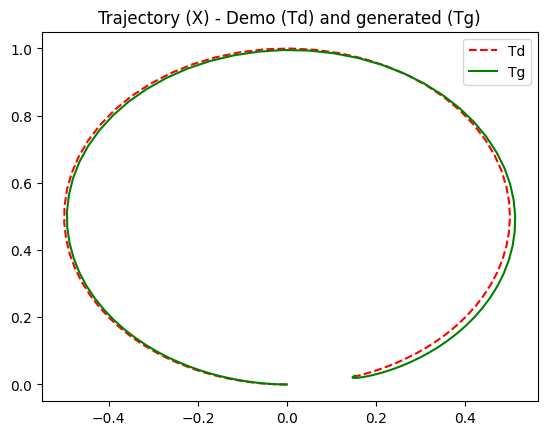

In [ ]:
"""
Train an original DMP with a circular traj and reproduce it.
"""
n_samples = 1
dims      = 2
bfs       = 30
tau       = 1.

freq      = 100
duration  = 1.
dt        = 1./freq

# Data generation
trajs_demo = gen_circular_traj(freq=freq, duration=duration)
print ("start:", trajs_demo[0, :, 0])
print ("goal:", trajs_demo[0,:, -1])

# Learn via DMP original/improved
dmp = DMPs_discrete(dims=dims, bfs=bfs, tau=tau, dt=dt,
                        enable_improved=False)
traj, _, _ = dmp.learn(trajs_demo)

# ReProduce a trajectory
y0   = None
goal = None

traj, _, _ = dmp.plan(y0=y0, goal=goal)

# print out your weights
print(dmp.w)

# plot the reproduced trajectory with demonstrations
plot_2d(traj, trajs_demo)

#### Improved DMPs

start: [-6.123234e-17  0.000000e+00]
goal: [0.1545085  0.02447174]
[[-4.36297642e-02 -2.06318983e-01 -6.04071632e-01 -1.24528152e+00
  -2.19702901e+00 -3.46383247e+00 -4.85997915e+00 -5.84025646e+00
  -5.39036842e+00 -2.18191008e+00  4.80599458e+00  1.52584664e+01
   2.66539295e+01  3.44611502e+01  3.39214052e+01  2.27362050e+01
   2.90865646e+00 -1.97497946e+01 -3.82739151e+01 -4.75662559e+01
  -4.58930842e+01 -3.43544236e+01 -1.53860703e+01  8.05396474e+00
   3.13992544e+01  4.51638908e+01  3.26358418e+01  4.26200842e+00
   1.60927322e-01  1.54507645e-01]
 [-1.86585653e-03 -4.50587389e-03  9.64772034e-03  1.12346547e-01
   4.67578753e-01  1.36922272e+00  3.23532597e+00  6.48882845e+00
   1.12505604e+01  1.68669417e+01  2.15196639e+01  2.23916736e+01
   1.67811677e+01  3.92702486e+00 -1.35671351e+01 -3.00690310e+01
  -3.93569946e+01 -3.78297592e+01 -2.63613085e+01 -9.62263501e+00
   6.48369810e+00  1.75601651e+01  2.22433083e+01  2.21231841e+01
   2.01734472e+01  1.76882034e+01  1.092

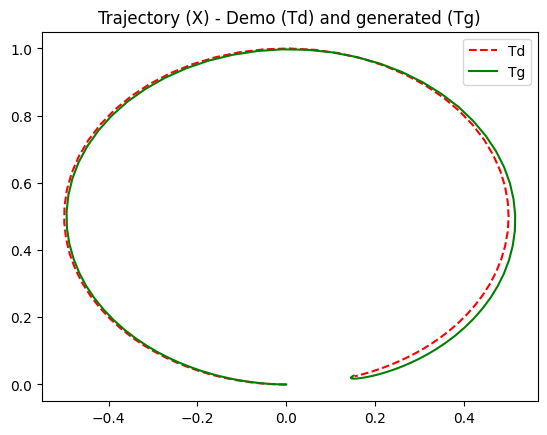

In [ ]:
"""
Train an improved DMP with a circular traj and reproduce it.
"""
n_samples = 1
dims      = 2
bfs       = 30
tau       = 1.

freq      = 100
duration  = 1.
dt        = 1./freq

# Data generation
trajs_demo = gen_circular_traj(freq=freq, duration=duration)
print ("start:", trajs_demo[0, :, 0])
print ("goal:", trajs_demo[0,:, -1])

# Learn via DMP original/improved
dmp = DMPs_discrete(dims=dims, bfs=bfs, tau=tau, dt=dt,
                        enable_improved=True)
traj, _, _ = dmp.learn(trajs_demo)

# ReProduce a trajectory
y0   = None
goal = None

traj, _, _ = dmp.plan(y0=y0, goal=goal)

# print out your weights
print(dmp.w)

# plot the reproduced trajectory with demonstrations
plot_2d(traj, trajs_demo)

## B. Adapt the learned DMPs with different goals.

You can now vary goals and analyze the difference between the original and improved DMPs


start: [-6.123234e-17  0.000000e+00]
goal: [0.1545085  0.02447174]


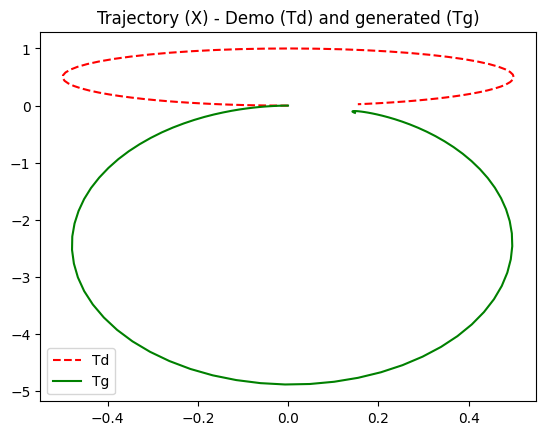

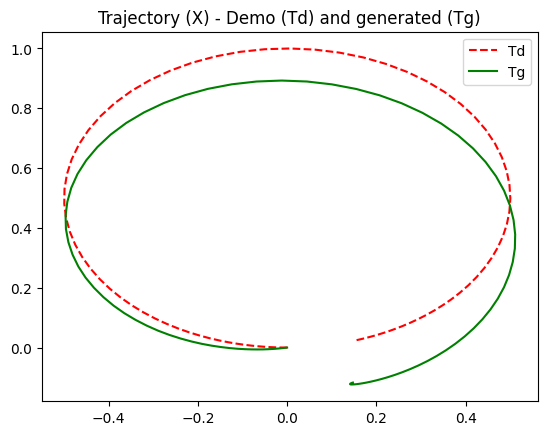

In [ ]:
"""
Train an original DMP with a circular traj and reproduce it with different goals.
"""
n_samples = 1
dims      = 2
bfs       = 30
tau       = 1.

freq      = 100
duration  = 1.
dt        = 1./freq

# Data generation
trajs_demo = gen_circular_traj(freq=freq, duration=duration)
print ("start:", trajs_demo[0, :, 0])
print ("goal:", trajs_demo[0,:, -1])

# ReProduce a trajectory
y0   = None #np.array([-0.5,])
goal = np.array([0.15,-0.12])


#------------------------------------------------------------
# Place your code herev
# Learn via DMP original/improved
dmp = DMPs_discrete(dims=dims, bfs=bfs, tau=tau, dt=dt,
                        enable_improved=False)
traj, _, _ = dmp.learn(trajs_demo)
traj, _, _ = dmp.plan(y0=y0, goal=goal)
plot_2d(traj, trajs_demo)

# Learn via DMP original/improved
dmp = DMPs_discrete(dims=dims, bfs=bfs, tau=tau, dt=dt,
                        enable_improved=True)
traj, _, _ = dmp.learn(trajs_demo)
traj, _, _ = dmp.plan(y0=y0, goal=goal)
plot_2d(traj, trajs_demo)

#------------------------------------------------------------


